In [1]:
import os
import cv2
import numpy as np

cwd = os.getcwd()
dir_hover = os.listdir(os.path.join(cwd,"Hover"))
dir_perch = os.listdir(os.path.join(cwd,"Perch"))
hover = []
perch = []

In [2]:
for i in dir_hover:
    img_h = cv2.imread(os.path.join(cwd,"Hover/{}".format(i)),cv2.IMREAD_GRAYSCALE)
    img_h = cv2.resize(img_h,(70,80))
    img_h_flat = img_h.reshape(-1,5600)
    img_h_flat = np.append(img_h_flat,0)
    hover.append([img_h_flat])
hover = np.concatenate(hover,axis=0)

for j in dir_perch:
    img_p = cv2.imread(os.path.join(cwd,"Perch/{}".format(j)),cv2.IMREAD_GRAYSCALE)
    img_p = cv2.resize(img_p,(70,80))
    img_p_flat = img_p.reshape(-1,5600)
    img_p_flat = np.append(img_p_flat,1)
    perch.append([img_p_flat])
perch = np.concatenate(perch,axis=0)

full = np.vstack((hover,perch))   

In [3]:
import copy
full_X = full[:,0:5600]
full_y = full[:,5600]
from sklearn.model_selection import train_test_split

# test_size: what proportion of original data is used for test set
train_img, test_img, train_lbl, test_lbl = train_test_split( full_X, full_y, test_size=0.2, random_state=2)
train_img_ori = copy.deepcopy(train_img)
test_img_ori = copy.deepcopy(test_img)

In [4]:
print(train_img.shape,train_img_ori.shape)

(8261, 5600) (8261, 5600)


In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(train_img)

C:\Users\Toby\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [6]:
# Apply transform to both the training set and the test set.
train_img = scaler.transform(train_img)
test_img = scaler.transform(test_img)

C:\Users\Toby\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int32 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [7]:
from sklearn.decomposition import PCA

# Make an instance of the Model
pca = PCA(.95)

pca.fit(train_img)
print("components retained",pca.n_components_)
train_img = pca.transform(train_img)
test_img = pca.transform(test_img)

components retained 697


In [8]:
from sklearn import svm
# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001)

# We learn the digits on the first half of the digits
classifier.fit(train_img, train_lbl)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=200)

bdt.fit(train_img, train_lbl)

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=1.0, n_estimators=200, random_state=None)

In [10]:
from sklearn import metrics
# Now predict the value of the digit on the second half:
expected = test_lbl
predicted = classifier.predict(test_img)

print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(expected, predicted))

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False):
             precision    recall  f1-score   support

          0       0.97      0.99      0.98      1314
          1       0.99      0.94      0.97       752

avg / total       0.98      0.98      0.98      2066


Confusion matrix:
[[1306    8]
 [  42  710]]


(2066, 697)
(50, 80, 70)


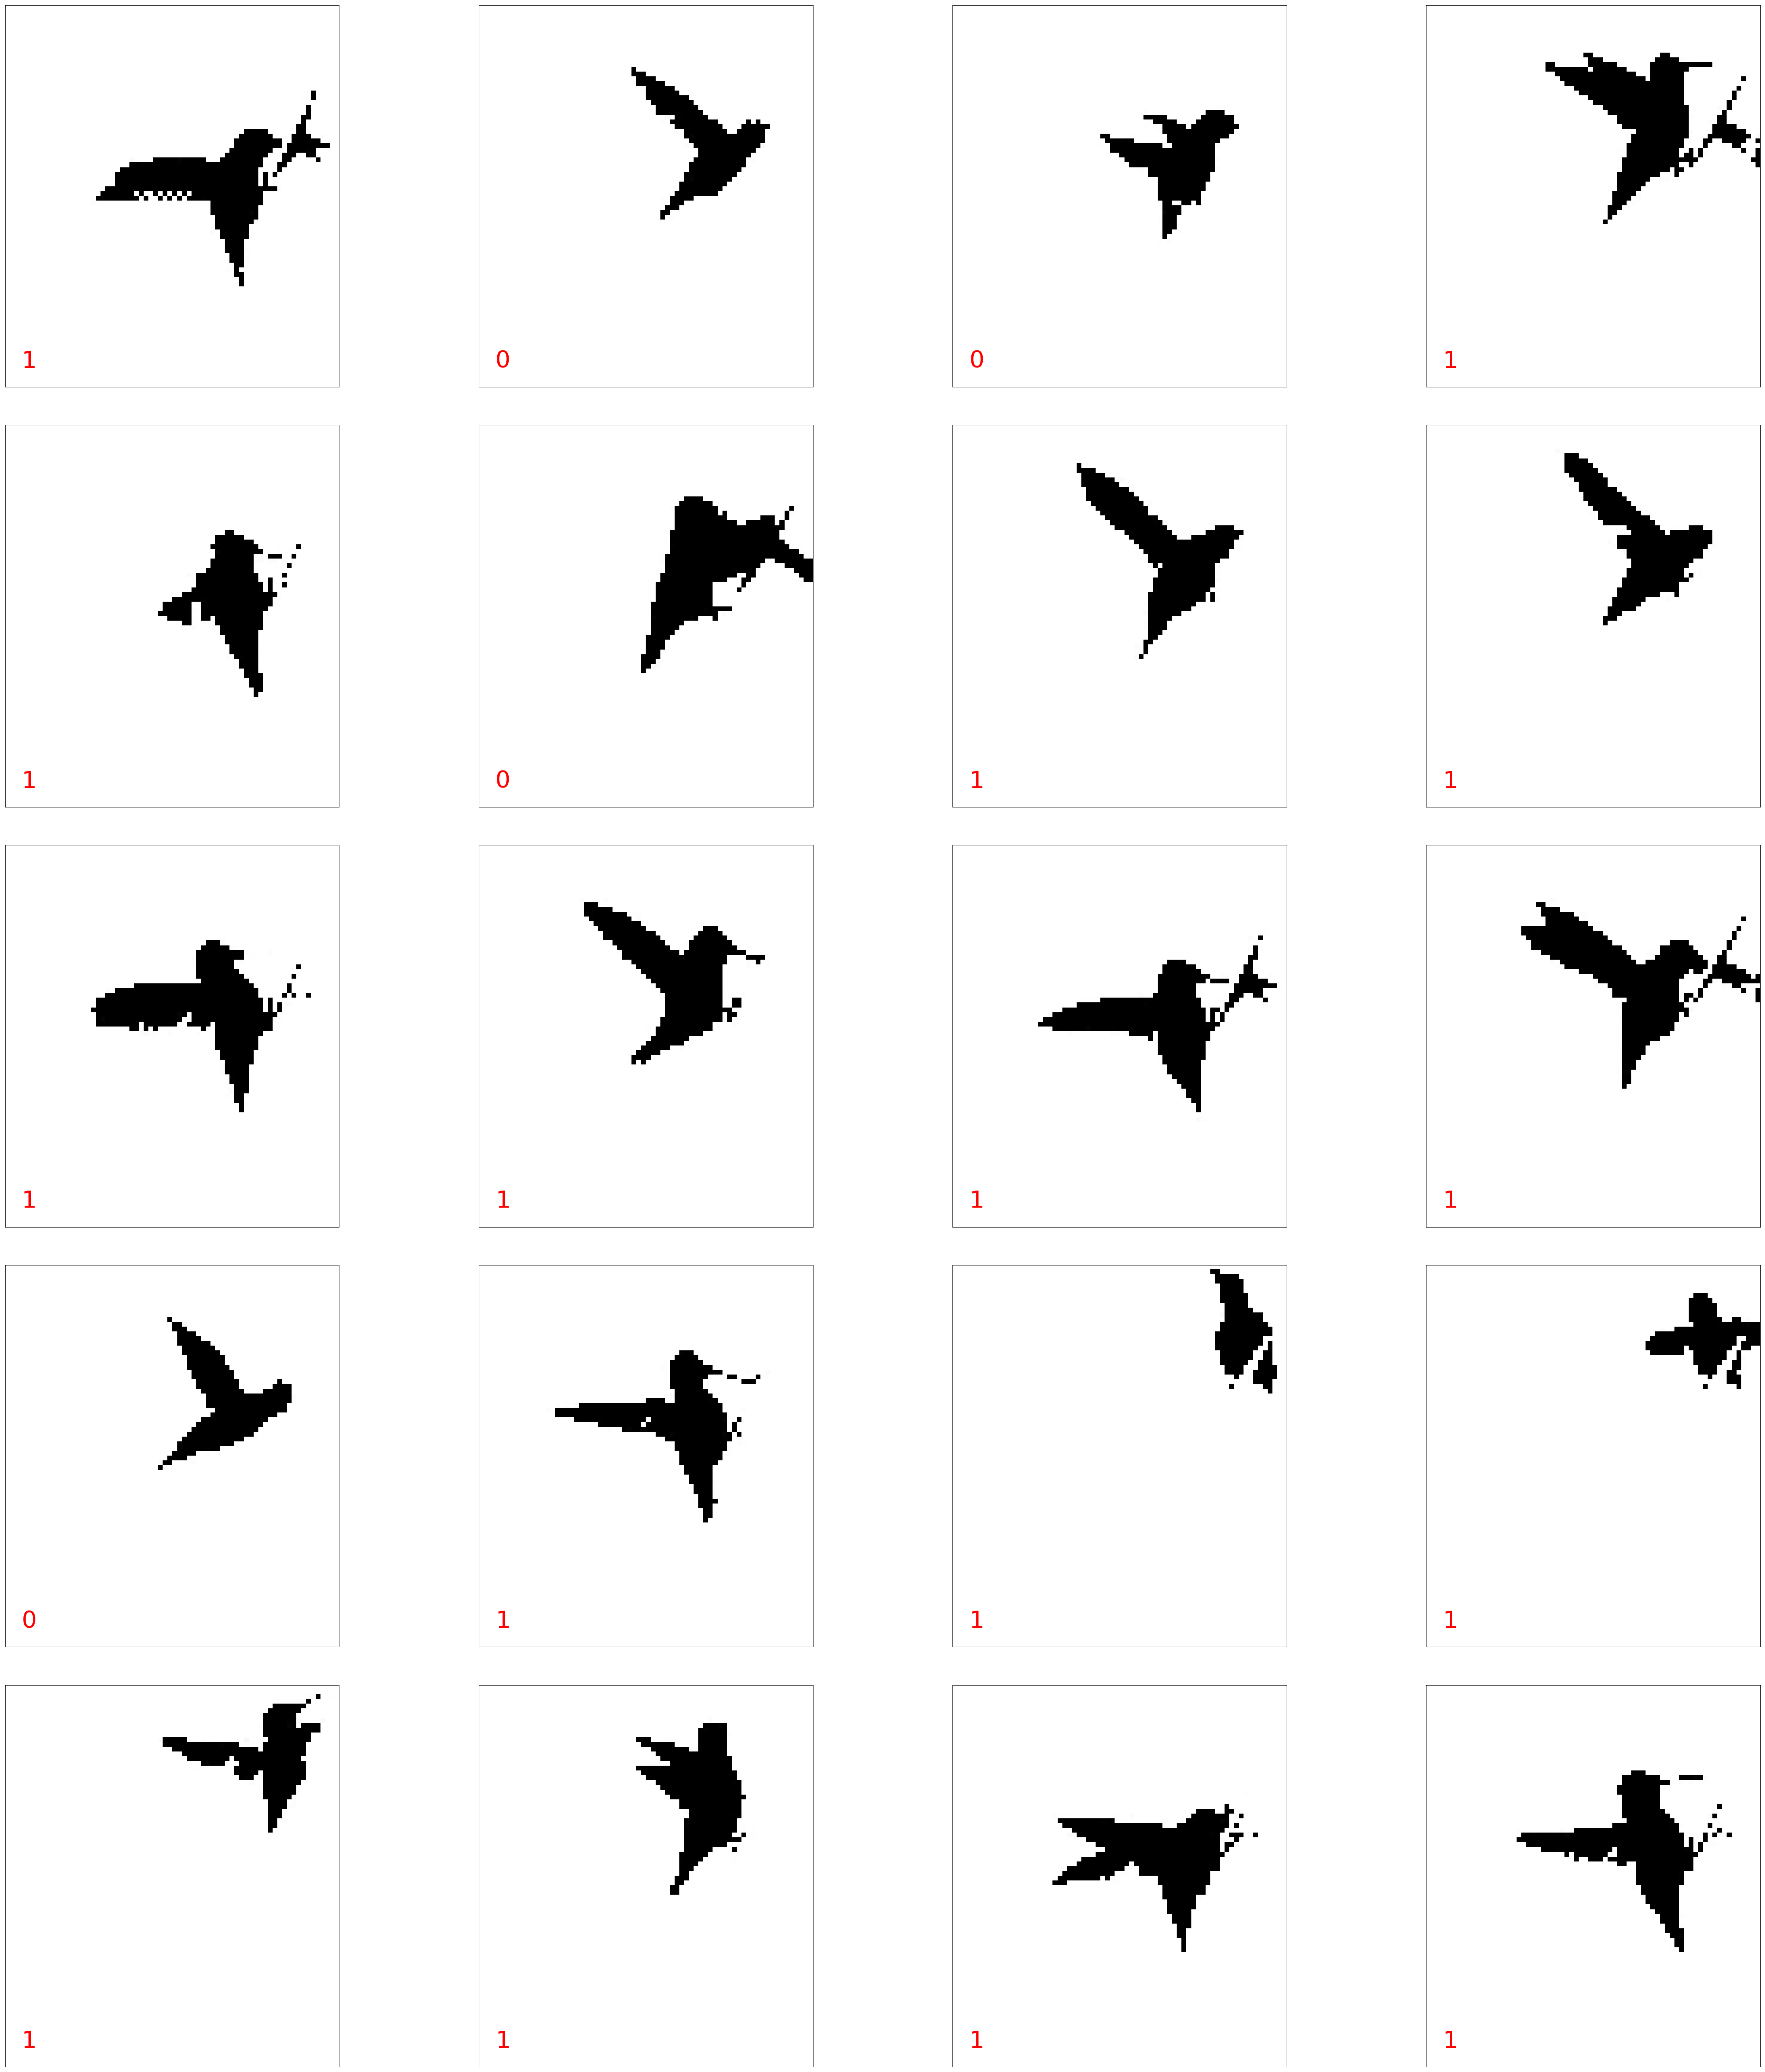

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline 
fig, axes = plt.subplots(5, 4, figsize=(70, 80),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

print(test_img.shape)
test_images = test_img_ori.reshape(-1,80, 70)
wrong_img = []
wrong_lbl = []
for i in range(len(predicted)):
    if test_lbl[i] != predicted[i]:
        wrong_img.append(test_images[i])
        wrong_lbl.append(test_lbl[i])
wrong_img = np.array(wrong_img)
print(wrong_img.shape)
for i, ax in enumerate(axes.flat):
    ax.imshow(wrong_img[i], cmap='binary', interpolation='nearest')
    ax.text(0.05, 0.05, str(wrong_lbl[i]),
            transform=ax.transAxes,
            fontsize=50,
            color='red' )

In [12]:
import pickle
pickle.dump(classifier, open("perch_hover_SVM.txt", 'wb'))
pickle.dump(scaler, open("perch_hover_scaler.txt", 'wb'))
pickle.dump(pca, open("perch_hover_pca.txt", 'wb'))
pickle.dump(bdt, open("perch_hover_bdt.txt", 'wb'))

In [13]:
print(test_lbl)

[0 0 0 ..., 1 0 0]


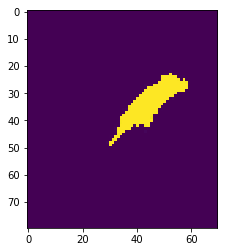

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img_h)